# Exercise: Counting Photons from a Faint Source

## Background: What Are We Measuring?
X-ray detectors in astronomy often record individual photon arrival times rather than flux measurements. Even if a star emits light at a constant average rate, the exact arrival times of photons fluctuate randomly.
These arrival times form what is called a **Poisson process**. Poisson processes are widely used whenever a process produces individual events that are independent of each other (i.e. the previous event does not predict the arrival of the next one). Other examples from physics include radioactive decays, earthquakes, and particle arrivals.
Each second, the number of photons detected is random, even if the source emits constant flux with an average rate $\lambda$. This average rate $\lambda$ is usually unknown and interesting to us, because it is a proxy for the apparent brightness of the star. 

## Simulating Photon Arrival Times
Let’s simulate photon arrivals for a star with an average photon rate of λ = 5 photons per second, over a 10-second observation.

In [1]:
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, fixed
import ipywidgets as widgets
from IPython.display import display

import numpy as np
from scipy.stats import poisson

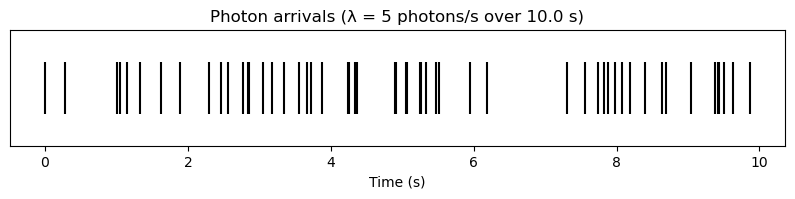

Total photons detected: 54


In [2]:
# Simulation parameters
lambda_rate = 5  # photons per second
duration = 10.0  # seconds

# Simulate the number of photons: total number of photons is the rate (per second) times the duration
n_photons = np.random.poisson(lam=lambda_rate * duration)

# Draw random arrival times 
# Poisson events are uniformly distributed over [0, duration]
arrival_times = np.sort(np.random.uniform(0, duration, size=n_photons))

plt.figure(figsize=(10, 1.5))
plt.eventplot(arrival_times, colors='black', lineoffsets=0)
plt.xlabel("Time (s)")
plt.title(f"Photon arrivals (λ = {lambda_rate} photons/s over {duration} s)")
plt.yticks([])
plt.show()

print(f"Total photons detected: {n_photons}")

## ME NOTES: 
* why is it meaningful to think about a rate (parameter that talks about rate of arrivals over time), even though the individual events are random? 
    * Coen: intervals are not always that interesting, but average is more important... photon arrival rates make more sense here
    * Daniela: problems where distance between arrivals are very important, but overall what we want to think about is the overall behavior integrated over time rather than the individual random events
    * also, we build these empirical plots... highlight: there is a theoretical description that is related to the data that we collect: the more data you collect, the more the data matches the theoretical description (look at the slider bars in the interactive plot!)

**Discuss with a partner:**
* Do the photons arrive at regular intervals?
* Why is it still meaningful to talk about a rate λ, even though individual events are random?

**why is the rate 5 per second but you end up with 36??**

## From Time Series to Counts

Now we’ll **bin** the photon arrivals into 1-second intervals, similar to how we might bin astronomical event data to generate a light curve (a time series of brightness measurements).


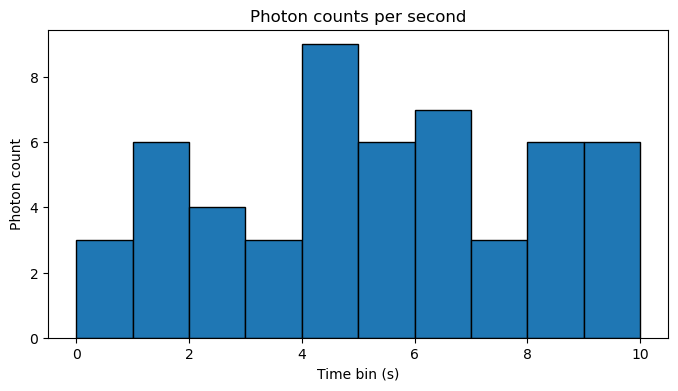

In [12]:
# compute bin edges, then make histogram
bin_edges = np.arange(0, duration + 1, 1)
counts, _ = np.histogram(arrival_times, bins=bin_edges)

plt.figure(figsize=(8, 4))
plt.bar(bin_edges[:-1], counts, width=1, align='edge', edgecolor='black')
plt.xlabel("Time bin (s)")
plt.ylabel("Photon count")
plt.title("Photon counts per second")
plt.show()

**Discuss with a partner:**
* Are all bins the same height? Why or why not?
* How could you summarize the overall behavior of this random variation?

## Building the Distribution

Let’s now repeat the experiment many times — say 1000 times — and look at the distribution of counts we might expect.


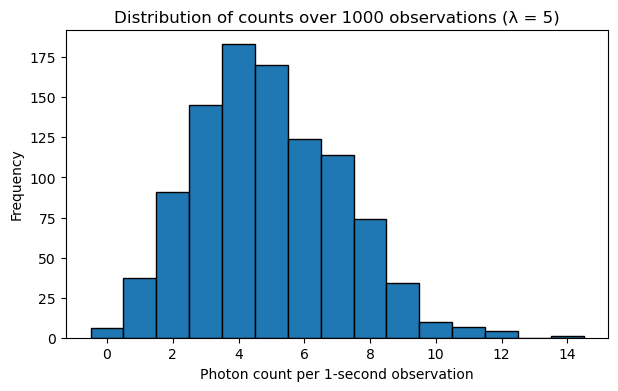

In [13]:
n_observations = 1000 # number of repeated experiments
duration = 1.0  # 1-second bins
lambda_rate = 5 # true underlying rate --> DO NOT USE lambda as a parameter! Protected python keyword!!!

# generate number of counts for 1000 observations
counts = np.random.poisson(lam=lambda_rate * duration, size=n_observations)

# plot a histogram
plt.figure(figsize=(7, 4))
plt.hist(counts, bins=np.arange(0, max(counts)+2)-0.5, edgecolor='black') # what is this doing? 
plt.xlabel("Photon count per 1-second observation")
plt.ylabel("Frequency")
plt.title(f"Distribution of counts over {n_observations} observations (λ = {lambda_rate})")
plt.show()

**Discuss with a partner**
* What is the most common count value?
* Is the distribution symmetric or skewed?
* How does this relate to the random arrivals you saw earlier?

## Interactive Exploration with ipywidgets
Let’s explore how the true brightness $\lambda$ affects the distribution.
Use the slider to change $\lambda$ and see the histogram update.

In [14]:
@interact(lambda_rate=widgets.FloatSlider(value=5, min=0.1, max=100, step=0.1, description='λ (rate)'))
def plot_photon_histogram(lambda_rate):
    """
    Plot a histogram of 1000 repeated observations of a Poisson variable,
    given a true rate defined in `lambda_rate`

    Parameters
    ----------
    lambda_rate : float
        The rate to use when drawing Poisson variables
    """
    # number of observations fixed
    n_observations = 1000

    # draw Poisson counts for `n_observation`
    counts = np.random.poisson(lam=lambda_rate, size=n_observations)

    # make histogram
    plt.figure(figsize=(7, 4))
    plt.hist(counts, bins=np.arange(0, max(counts)+2)-0.5, edgecolor='black', color='skyblue')
    plt.xlabel("Photon count per observation")
    plt.ylabel("Frequency")
    plt.title(f"Photon count distribution (λ = {lambda_rate:.1f})")
    plt.show()

interactive(children=(FloatSlider(value=5.0, description='λ (rate)', min=0.1), Output()), _dom_classes=('widge…

**Discuss with a partner:**
* How does increasing or decreasing $\lambda$ change the shape of the histogram? What happens if you make $\lambda$ really small? What happens if $\lambda$ is really big?
* What happens to the relative variability (the width compared to the mean)?
* For large $\lambda$, what kind of (maybe familiar?) shape does the distribution resemble?

## The Poisson Probability Mass Function: Theory vs. Data

So far, we have:
- simulated photon counts in many identical measurements (e.g. time bins or pixels),
- and looked at the **histogram** of these counts.

Now we connect that empirical picture to the **theoretical model**:  
the **Poisson distribution** for the photon counts.

If the expected number of counts per measurement is \(\lambda\), then the
probability of observing exactly \(k\) counts in one measurement is

$$
P(K = k; \lambda) = \frac{e^{-\lambda} \lambda^k}{k!}, \quad k = 0, 1, 2, \dots
$$

This is called the **probability mass function (PMF)** of the Poisson distribution.

In a simulation with $N$ independent measurements:
- we can estimate this PMF empirically by the **relative frequencies** of each count value $k$,
- and we can compare these relative frequencies to the theoretical Poisson PMF.

**Exercise**:
* Change the sliders below. As you change the number of measurements, how does your empirical approximation of the Poisson distribution change?

In [15]:
def simulate_poisson_counts(lambda_rate, n_observations, random_state=None):
    """
    Helper function to simulate n_measurements independent Poisson counts
    with mean lambda_rate.

    Parameters
    ----------
    lambda_rate : float
        The Poisson rate to use for simulating counts

    n_observations : int
        The number of repeated experiments to simulate

    random_state : int
        Set the random number generator state for 
        reproducibility

    Returns
    -------
    counts : numpy.ndarray of shape (n_observations, 1)
        The array of simulated counts
    """
    rng = np.random.default_rng(random_state)
    counts = rng.poisson(lambda_rate, size=n_observations)
    return counts


def plot_empirical_vs_theoretical(lambda_rate=3.0, n_observations=50):
    """
    Simulate Poisson counts and compare the empirical
    relative frequencies to the theoretical Poisson PMF.

    Parameters
    ----------
    lambda_rate : float
        The Poisson rate to use for simulating counts

    n_observations : int
        The number of repeated experiments to simulate
    """
    # Simulate data
    counts = simulate_poisson_counts(lambda_rate, n_observations)
    
    # Choose a sensible range of k values to display
    k_max = max(counts.max(), int(lambda_rate + 4 * np.sqrt(lambda_rate)))  # a few sigma above mean
    k_values = np.arange(0, k_max + 1)
    
    # Empirical relative frequencies
    empirical_counts = np.array([(counts == k).sum() for k in k_values])
    empirical_freq = empirical_counts / n_observations
    
    # Theoretical Poisson PMF
    pmf = poisson.pmf(k_values, lambda_rate)
    
    # Plot
    fig, ax = plt.subplots()
    
    # Empirical as bars
    ax.bar(k_values - 0.2, empirical_freq, width=0.4,
           alpha=0.6, label="Empirical (relative frequency)")
    
    # Theoretical as points + line
    ax.plot(k_values + 0.2, pmf, "o-", label="Theoretical Poisson PMF")
    
    ax.set_xlabel("Photon count k")
    ax.set_ylabel("Probability / Relative frequency")
    ax.set_title(fr"Poisson($\lambda$ = {lambda_rate:.1f}),  N = {n_observations} observations")
    ax.legend()
    plt.tight_layout()
    plt.show()


interact(
    plot_empirical_vs_theoretical,
    lambda_rate=FloatSlider(
        value=3.0, min=0.5, max=20.0, step=0.5,
        description="λ (mean counts)"
    ),
    n_observations=IntSlider(
        value=20, min=5, max=1000, step=5,
        description="N observations"
    )
);

interactive(children=(FloatSlider(value=3.0, description='λ (mean counts)', max=20.0, min=0.5, step=0.5), IntS…

**Discuss with a partner**:
* How many measurements do you think you'll need to get a reliable estimate of the distribution, and of the true underlying Poisson rate?

**STOP HERE!** We'll go back to the lecture a bit before we tackle the next part!

## Interlude: Modelling Commuting Delays & The Central Limit Theorem

You commute to campus. Your total commute time can be modeled as:

$$
T = T_0 + \sum_{i=1}^{N}D_i
$$

where you are subjected to $N$ small delays $D_i$ (e.g. stops at traffic lights, bicycle traffic jams, slowdowns due to tourists on bike paths ...).

In reality the delays are often skewed: many are small, a few are large (e.g. you need to take a detour because a road is closed). We'll use an exponential distribution to approximate this shape:

In [ ]:
def normal_pdf(x, mu, sigma):
    """
    Probability density function of the Gaussian distribution

    Parameters
    ----------
    x : float or array
        The value (or list of values) at which to evaluate the distribution

    mu : float
        The mean of the distribution

    sigma : float
        the standard deviation of the distribution
    """
    return (1.0/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5*((x-mu)/sigma)**2)

def simulate_commutes(N, M, model="exponential", baseline=20.0, seed=0):
    """
    Simulate M commutes.
    Each commute: baseline + sum of N i.i.d. delays.

    Parameters
    ----------
    N : int 
        number of delays

    M : int
        Number of commutes to simulate

    model : str, one of (exponential | lognormal)
        The distribution for the individual delays

    baseline : float 
        the baseline delay we expect

    seed : int
        random seed for reproducibility
    
    Returns
    -------
    totals : array of shape (M,)
        Total commute times
    """
    rng = np.random.default_rng(seed)

    if model == "exponential":
        # skewed, mean=1, std=1
        delays = rng.exponential(scale=1.0, size=(M, N))
        mu_d, sigma_d = 1.0, 1.0
        totals = baseline + delays.sum(axis=1)

    elif model == "lognormal":
        # long tail but finite variance
        mu_ln, sigma_ln = 0.0, 0.6
        delays = rng.lognormal(mean=mu_ln, sigma=sigma_ln, size=(M, N))
        mu_d = np.exp(mu_ln + sigma_ln**2/2)
        var_d = (np.exp(sigma_ln**2)-1)*np.exp(2*mu_ln + sigma_ln**2)
        sigma_d = np.sqrt(var_d)
        totals = baseline + delays.sum(axis=1)

    else:
        raise ValueError("model must be 'poisson' or 'lognormal'")

    return totals, mu_d, sigma_d

Let's simulate commute times for:
* one delay component ($N=1$) and thirty delay components ($N=30$)
* use the Poisson delay model
* simulate $M=10000$ commutes

We'll make two histograms, one for each $N$. How do you expect the shapes of the histograms to compare?

In [ ]:
# Choose parameters
M = 10_000
baseline = 20.0
seed = 0
model = "exponential"

# Simulate for N=1 and N=30
totals1, mu1, sigma1 = simulate_commutes(N=1, M=M, model=model, baseline=baseline, seed=seed)
totals30, mu30, sigma30 = simulate_commutes(N=30, M=M, model=model, baseline=baseline, seed=seed)

# Plot histograms (density=True) in two separate figures
plt.figure(figsize=(7,4))
plt.hist(totals1, bins=60, density=True)
plt.title("Commute times with N=1 delay component")
plt.xlabel("minutes")
plt.ylabel("density")
plt.show()

plt.figure(figsize=(7,4))
plt.hist(totals30, bins=60, density=True)
plt.title("Commute times with N=30 delay components")
plt.xlabel("minutes")
plt.ylabel("density")
plt.show()


**Question**:
* Describe how the shape changes when you go from $N=1$ to $N=30$.
* What feature of the exponential distribution makes $N=1$ look “not Gaussian”?


### Watch the Distribution Gaussian-ify

Run the next cell and use the sliders. The curve overlay is the CLT Normal approximation for the **sum**:
- $\mathbb{E}[T] = T_0 + N\,\mu_D$
- $\mathrm{sd}(T) \approx \sqrt{N}\,\sigma_D$


In [ ]:
def clt_commute_demo(N=5, M=5000, model="exponential"):

    baseline = 20.0
    bins=60
    seed=0
    totals, mu_d, sigma_d = simulate_commutes(N=N, M=M, model=model, baseline=baseline, seed=seed)

    # CLT approximation for the *sum*:
    mu_T = baseline + N * mu_d
    sigma_T = np.sqrt(N) * sigma_d

    plt.figure(figsize=(8,4))
    plt.hist(totals, bins=bins, density=True)
    xs = np.linspace(np.percentile(totals, 0.5), np.percentile(totals, 99.5), 400)
    plt.plot(xs, normal_pdf(xs, mu_T, sigma_T), linewidth=2)
    plt.title(f"Total commute time (M={M} days), delay model={model}, N={N}")
    plt.xlabel("minutes")
    plt.ylabel("density")
    plt.show()

    print(f"Empirical mean(T) = {totals.mean():.3f}  |  CLT mean ≈ {mu_T:.3f}")
    print(f"Empirical std(T)  = {totals.std(ddof=1):.3f}  |  CLT std  ≈ {sigma_T:.3f}")

interact(
    clt_commute_demo,
    N=widgets.IntSlider(value=5, min=1, max=200, step=1, description="N"),
    M=widgets.IntSlider(value=5000, min=500, max=20000, step=500, description="M"),
    model=widgets.Dropdown(options=["exponential","lognormal"], value="exponential", description="model"),)


**Questions**
* For **exponential delays**, find the smallest $N$ where the Normal overlay is a “reasonable” approximation *by eye*. Record (1) your chosen $N$ and (2) your criterion for "reasonable"
* Switch to **lognormal delays**. Does it require larger or smaller $N$ to look Gaussian than the exponential case?

### The key quantitative check: scaling with $N$

The CLT predicts:
- $\mathrm{s}(T) \propto \sqrt{N}$ for the **sum**
- $\mathrm{s}(\bar{D}) \propto 1/\sqrt{N}$ for the **average delay** $\bar{D}=\frac{1}{N}\sum D_i$

where $\mathrm{s}$ is the standard deviation. For a range of $N$ values, estimate $\mathrm{sd}(T)$ from simulations and confirm the $\sqrt{N}$ scaling.



In [ ]:
Ns = np.array([1, 2, 3, 5, 10, 20, 50, 100, 200])
M = 20000
baseline = 20.0
seed = 1
model = "exponential"

std_T = []
for N in Ns:
    totals, mu_d, sigma_d = simulate_commutes(N=N, M=M, model=model, baseline=baseline, seed=seed)
    std_T.append(totals.std(ddof=1))
std_T = np.array(std_T)

# Log-log plot of std(T) vs N
plt.figure(figsize=(7,4))
plt.loglog(Ns, std_T, marker="o", linestyle="none", label="simulation")

# Reference line ~ sqrt(N), scaled to match the first point
ref = std_T[0] * np.sqrt(Ns / Ns[0])
plt.loglog(Ns, ref, linewidth=2, label=r"reference $\propto \sqrt{N}$")

plt.xlabel("N (number of delay components)")
plt.ylabel("std(T) over simulated days")
plt.title("Scaling check: std(T) vs N")
plt.legend()
plt.show()


## Using the Poisson Cumulative Distribution Function for X-ray Source Detection

In real X-ray images, we often measure counts in a **source region** and a nearby
**background region**.

Even if no true source is present, random fluctuations of the background can
produce apparent "hot pixels".  
To decide whether an observed count excess is significant, we ask:

> What is the probability of observing $k_\mathrm{obs}$ or more counts purely by chance,
> if the true mean background is $λ_b$?

Imagine the true mean background rate is ~5 photons/second. In a one-second observation, we have observed $k_\mathrm{obs} = 10$ photons. 

**Discuss with a partner**:
* Can you think of reasons why we might want the probability for $k_\mathrm{obs}$ *or more counts* rather than just $k_\mathrm{obs}$ counts?
* Use the slider in the Figure from the earlier Poisson exercise above to plot the empirical distribution and theoretical probability mass function for the background rate and a large number of repeated observations $N$. Do you think the 10 photons we detected constitute a signal from a real astronomical source? Or do you think they're just noise?

###  The Cumulative Distribution Function

To answer this question, we need to know the probability *above* the observed value. Remember that the distribution defines a *probability density*, so the *probability* is defined as the *integral* of the PDF between two limits. So what we'd like to know is the integral of the distribution *above* the observed value. Thankfully, there is a related, well-defined quantity in statistics: the cumulative distribution function! The CDF describes the probability in the distribution from negative infinity up to a given value. We'll explore this more in the lecture in the moment, but for now, here's the CDF for the Poisson distribution.

The probability we need comes from the **Poisson CDF**:
$$
P(K \ge k_\text{obs}) = 1 - F(k_\text{obs}-1; \lambda_b)
$$

If this function defines the integrated probability *up* to a certain point, then the probability above must be, by the definition of the probability distribution, 1-CDF (since the whole distribution must integrate to 1). This also has a name: the **survival function**, which we can use to define the tail probability above the observed value.

If this tail probability is very small, the excess is unlikely to be due to chance (i.e. due to background). This *may* be evidence for the presence of a source, but stay tuned for the next lecture on hypothesis testing! There are complications!

In [ ]:
def poisson_cdf_and_sf(lambda_b=3.0, k_obs=8):
    """
    Plot the cumulative distribution function (CDF) and the 
    Survival Function (SF) for the Poisson distribution. 

    Parameters
    ----------
    lambda_b : float, default = 3.0
        The background Poisson rate

    k_obs : int, default = 8
        The number of counts in our single observation
    """
    k = np.arange(0, max(15, int(lambda_b * 4)))
    pmf = poisson.pmf(k, lambda_b)
    cdf = poisson.cdf(k, lambda_b)
    p_tail = 1 - poisson.cdf(k_obs - 1, lambda_b)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), sharex=True, sharey=True)
    ax1.bar(k, pmf, alpha=0.5, label="Poisson PMF")
    ax1.step(k, cdf, where="post", color="C1", label="Cumulative (CDF)")
    ax1.axvline(k_obs, color="red", linestyle="--", label=f"k_obs = {k_obs}")
    #ax1.text(k_obs + 0.3, 0.1, f"P(K ≥ {k_obs}) = {p_tail:.3f}",
    #        color="red", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
    ax1.set_xlabel("Photon count k")
    ax1.set_ylabel("Probability")
    ax1.set_title(f"Poisson model with λ_b = {lambda_b:.1f}")
    ax1.legend()

    ax2.bar(k, pmf, alpha=0.5, label="Poisson PMF")
    ax2.step(k, 1-cdf, where="post", color="C2", label="Survival function (1-CDF)")

    ax2.axvline(k_obs, color="red", linestyle="--", label=f"k_obs = {k_obs}")
    ax2.text(k_obs + 0.3, 0.1, f"P(K ≥ {k_obs}) = {p_tail:.3f}",
            color="red", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
    ax2.set_xlabel("Photon count k")
    ax2.set_ylabel("Probability")
    ax2.set_title(f"Poisson model with λ_b = {lambda_b:.1f}")
    ax2.legend()

    plt.tight_layout()
    plt.show()

interact(
    poisson_cdf_and_sf,
    lambda_b=FloatSlider(value=3.0, min=0.5, max=15.0, step=0.1, description="λ_b"),
    k_obs=IntSlider(value=8, min=0, max=25, step=1, description="k_obs")
);

**Discuss with a partner**: 

1. Try λ_b = 5 and move k_obs from 0 to 15.
   - For which k_obs does P(K ≥ k_obs) fall below 0.05?
   - Are our $k=10$ counts from above likely due to the background?

2. If you double the background level (λ_b = 10), how does that change the
   threshold for a "significant" detection?




## From Simulations to Real Data

Now, let’s connect our simulation to real photon arrival data.
This is a NASA NICER observation of the accreting black hole MAXI 1820+070 during its 2018 outburst. The actual observation is 2.4GB big (accreting black holes in outburst produce a *lot* of photons!), so this is a tiny piece of it.


In [ ]:
# NOTE: CHANGE THIS DIRECTORY TO WHERE YOU'VE SAVED THE DATA FILE!
datadir = "./"

In [ ]:
# THIS CODE MADE THE TEXT FILE YOU'RE USING! LEAVE IT COMMENTED OUT!
"""
# name of the data file
fname = "data_smaller.hdf5"

data = hdf5.read_table_hdf5(datadir + fname)
energy = data["energy"]
time = data["time"]

time = np.array(time - time[0])

lc = stingray.Lightcurve.make_lightcurve(time[time < 1], dt=0.0005)

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(lc.time, lc.counts)

outname_small = "MAXI1820+070_1200120106_1s.dat"
np.savetxt(datadir + outname_small, time[time < 1])

outname_large = "MAXI1820+070_1200120106_100s.dat"
np.savetxt(datadir + outname_large, time[time < 100])
"""


Let's first load the prepared event list:

In [ ]:
fname = "MAXI1820+070_1200120106_1s.dat"

arrival_times_real = np.loadtxt(datadir + fname)

In [ ]:
arrival_times_real

This is a list of ~26000 photons, all recorded within a single second of observations from this accreting black hole. Let's plot the first 100 or so:

In [ ]:
plt.figure(figsize=(10, 1.5))
plt.eventplot(arrival_times_real[:100], colors='black', lineoffsets=0)
plt.xlabel("Time (s)")
plt.title(f"NICER Photon arrivals")
plt.yticks([])
plt.show()


In [ ]:
bin_edges = np.arange(arrival_times_real.min(), arrival_times_real.max(), 0.001)
counts_real, _ = np.histogram(arrival_times_real, bins=bin_edges)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(bin_edges[:-1], counts_real, lw=1, color="black", ds="steps-mid")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Counts per 0.001 second bin")


ax2.hist(counts_real, bins=np.arange(0, max(counts_real)+2)-0.5, edgecolor='black', color='lightcoral')
ax2.set_xlabel("Photon count per 0.001-second bin")
ax2.set_ylabel("Frequency")
ax2.set_title("Observed distribution of counts (NICER data)")
plt.show()

**Exercises** 
* *Do we have a source in the data?* The NICER background rate is generally low, but also highly variable, due to cosmic rays, space weather, particles from the environment, and the South Atlantic Anomaly. Here, let's assume that the background rate for this observation was 15 counts per 0.001 second bin. Do you think we've detected a source? 
* We often want to know what the true flux of the source is, since that can tell us how much energy the source emitted isotropically. Think about how you could estimate the true underlying count rate (a quantity you can convert into the flux if you know some of the details of the instrument) from the data. What (simple!) quantity or quantities would you calculate?
* Below, I've given you a simple, visual way of parameter estimation by comparing the observed histogram of the flux to simulated histograms with different count rates. Move the slider to roughly estimate what you think the true count rate might be. Does it agree with whatever metric you calculated above?



In [ ]:
@interact(lambda_guess=widgets.FloatSlider(value=5, min=1, max=100, step=0.5, description='λ (guess)'))
def compare_to_real(lambda_guess):
    simulated = np.random.poisson(lam=lambda_guess, size=len(counts_real))
    plt.figure(figsize=(7, 4))
    plt.hist(counts_real, bins=np.arange(0, max(counts_real)+2)-0.5, alpha=0.6, label="Real data")
    plt.hist(simulated, bins=np.arange(0, max(simulated)+2)-0.5, alpha=0.6, label="Simulated (λ guess)")
    plt.xlabel("Photon count per bin")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Compare simulated and observed count distributions")
    plt.show()

**Questions**:
* What approximate λ value best matches the observed distribution?
* How does your “eyeballed” inference compare to the average count per bin in the real data?
* Why might the match not be perfect? (Consider variability, background, instrumental effects.)

In [ ]:
np.mean(counts_real)

## Reflection and Connection to Inference
You’ve just performed a primitive form of inference: you adjusted a model parameter ($\lambda$) until its predicted distribution matched the data.

Later in the course, we’ll formalize this process mathematically by
* quantifying “goodness of fit” with likelihoods
* exploring uncertainty using posterior distributions

But conceptually, the key ideas are already here:
* Data are realizations of random processes
* Models describe the expected distribution of those data
* Inference is the process of finding model parameters that best explain what we observed